In [21]:
import os
import sys

from qutip import *
from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, Aer,
    execute
)
from qiskit.tools.visualization import plot_histogram

assert sys.version_info >= (3,5), "Only Python 3.5 or greater supported."

# import state tomography functions
from qiskit.tools.visualization import plot_histogram, plot_state

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from qiskit import IBMQ
from qiskit import execute
from qiskit.providers.ibmq import least_busy

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import BasicAer
from qiskit import *
import qiskit_aqua
from qiskit_aqua.algorithms import AmplitudeEstimation
from qiskit_aqua.components.uncertainty_problems import EuropeanCallExpectedValue, EuropeanCallDelta
from qiskit_aqua.components.random_distributions import LogNormalDistribution

from qiskit.tools.visualization import plot_histogram, plot_state

In [9]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 1

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x7fa239186390>,
 <a list of 2 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

Text(0.5, 0, 'Spot Price at Maturity $S_T$ (\\$)')

Text(0, 0.5, 'Probability ($\\%$)')

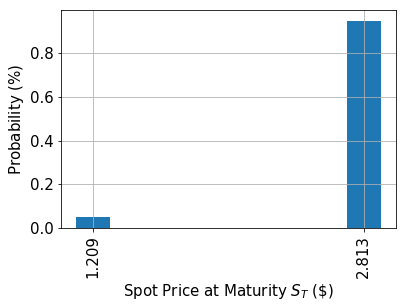

In [10]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

In [11]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

In [12]:
range(7,13)

range(7, 13)

In [13]:
# number of ancillary qubits = number in uncertainty model+2
anc_qubits = num_uncertainty_qubits+2
N = num_uncertainty_qubits + anc_qubits

q = QuantumRegister(N)
c = ClassicalRegister(N)
qc = QuantumCircuit(q,c)
european_call.build(qc,q, q_ancillas=[q[i] for i in range(anc_qubits, N)])
qc.measure(q,c)
for i in range (0,7):
   qc.measure(q[i],c[i])

QiskitIndexError: 'register index out of range'

In [14]:
IBMQ.save_account('b570d41d223d1bbc8ff22961c8cfa480466c67d68c715daf655d4e6706831aac94133a6bc89b8496485295e5861ba7f6d6ec02d2eb2269783d874d265003a19d')

/usr/share/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/credentials/_configrc.py:129: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. Set overwrite=True to overwrite.')


In [15]:
IBMQ.load_accounts()

In [28]:
device = least_busy(IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 13 and not x.configuration().simulator))
device

<IBMQBackend('ibmq_16_melbourne') from IBMQ()>

In [29]:
job = execute(qc, device)

In [30]:
result = job.result()

/usr/share/anaconda3/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [31]:
counts_exp = result.get_counts(qc)

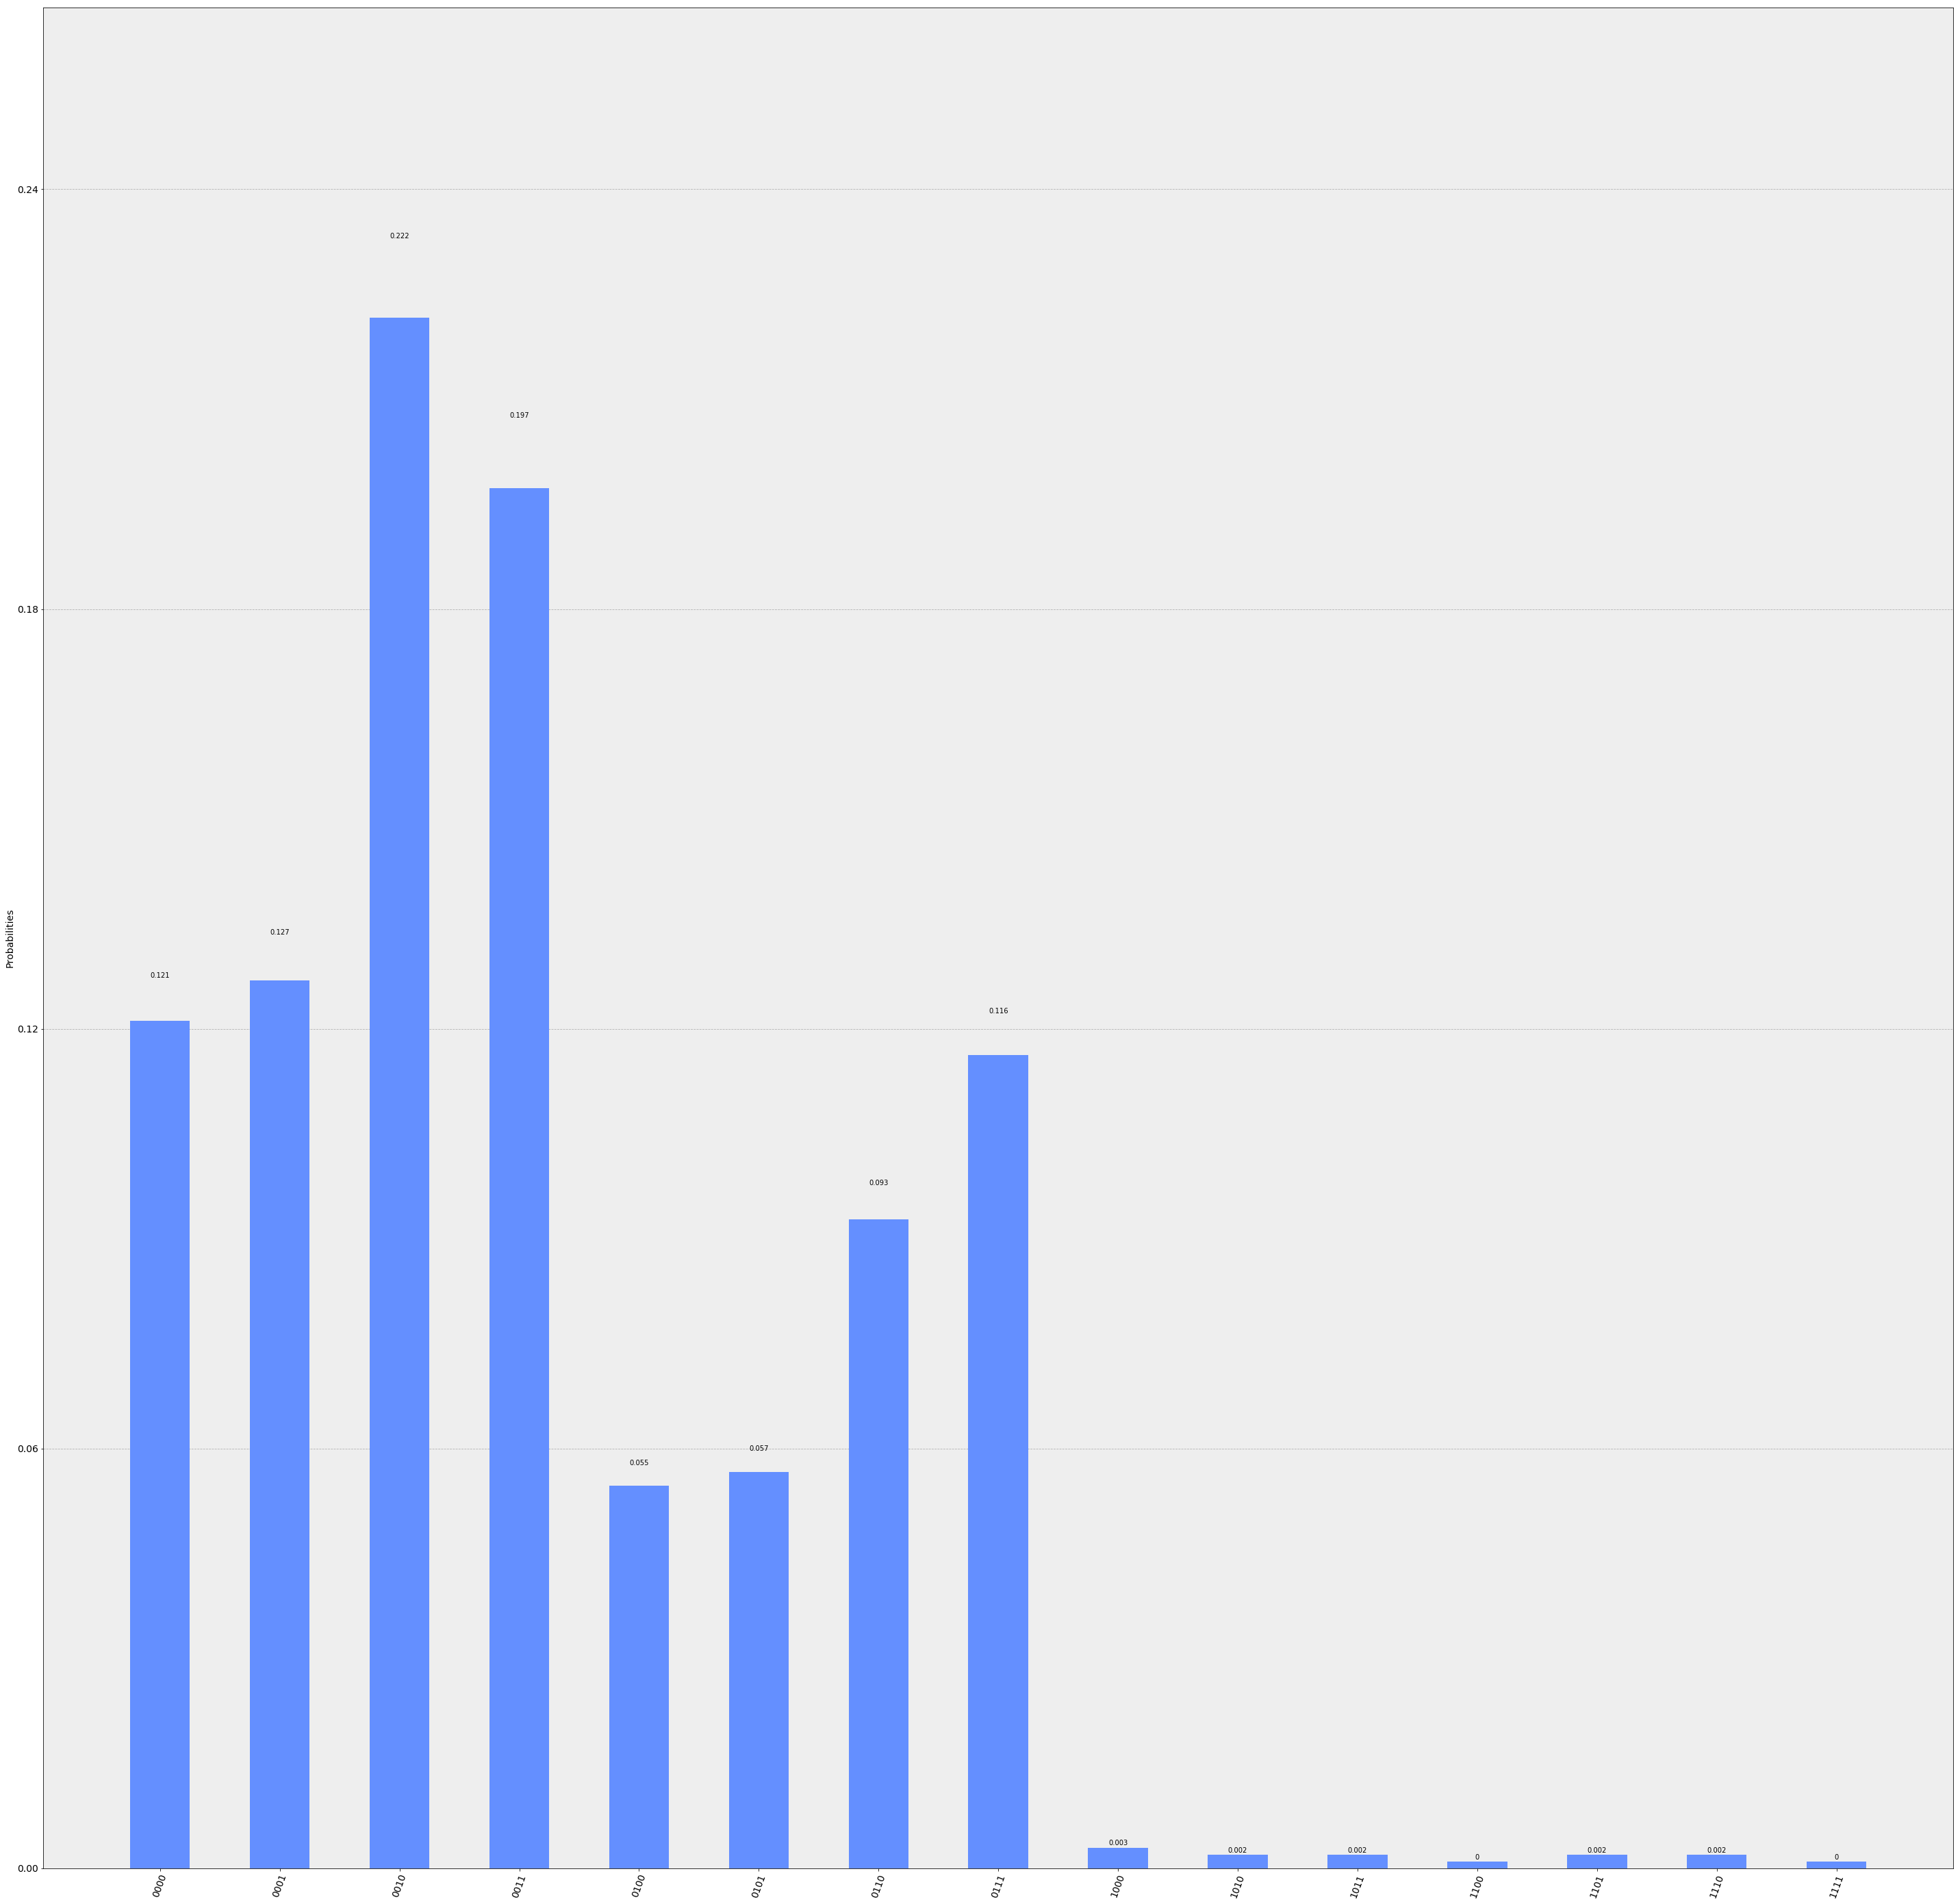

In [32]:
plot_histogram(counts_exp, figsize=[50,50])

# Amplitude Estimation

In [33]:
# set number of evaluation qubits (samples)
m = 1

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)

result = ae.run(quantum_instance=device)

<BarContainer object of 2 artists>

NameError: name 'exact_value' is not defined

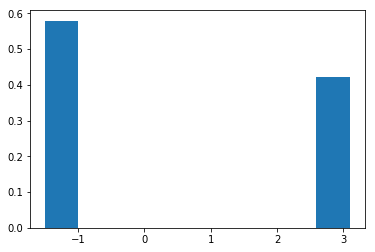

In [36]:
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()